In [ ]:
%tensorflow_version 1.x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/Colab Notebooks/generative-dog-images/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!wget -O 'images.tar' 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'

--2019-12-01 11:15:52--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  59.7MB/s    in 25s     

2019-12-01 11:16:17 (30.4 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [ ]:
!wget -O 'annotation.tar' 'http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar'

--2019-12-01 11:16:18--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  39.0MB/s    in 0.5s    

2019-12-01 11:16:19 (39.0 MB/s) - ‘annotation.tar’ saved [21852160/21852160]



In [ ]:
!mkdir 'generative-dog-images'
!mkdir 'generative-dog-images/annotation'
!mkdir 'generative-dog-images/all-dogs'

In [ ]:
!tar -xf 'images.tar' -C 'generative-dog-images/all-dogs/'

In [ ]:
!tar -xf 'annotation.tar' -C 'generative-dog-images/annotation/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import joblib
import time
import imageio
from tqdm import tqdm
import xml.etree.ElementTree as ET 

import PIL
from IPython.display import clear_output

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Reshape, BatchNormalization, ReLU, LeakyReLU, Dropout, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, InputSpec

In [ ]:
tf.enable_eager_execution()

In [ ]:
ROOT = 'generative-dog-images/'
BREEDS = os.listdir(ROOT + 'annotation/Annotation/')

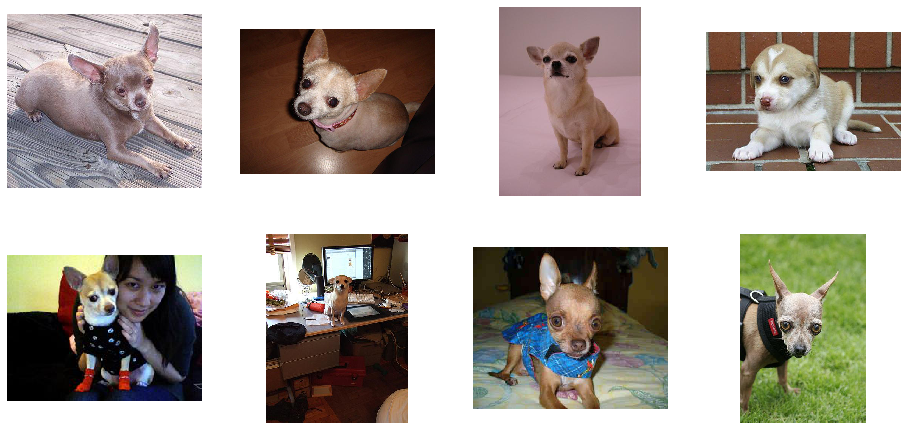

In [ ]:
fig = plt.figure(figsize=(16,16))

sample = glob.glob('generative-dog-images/all-dogs/Images/n02085620-Chihuahua/*')[:8]
for i, image in enumerate(sample):
    plt.subplot(4, 4, i+1)
    img = plt.imread(image)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
def take_only_dogs():
    images_ds = np.zeros((22126, 64, 64, 3))
    idx = 0
    for breed in tqdm(BREEDS):
        for dog in os.listdir(ROOT + 'annotation/Annotation/' + breed):
            try:
                img = PIL.Image.open(ROOT + 'all-dogs/Images/' + breed + '/' + dog + '.jpg').convert('RGB')
            except:
                continue
            tree = ET.parse(ROOT + 'annotation/Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin + w, ymin + w))
                img2 = img2.resize((64,64), PIL.Image.ANTIALIAS)
                images_ds[idx,:,:,:] = img2
                idx += 1
    return images_ds

In [ ]:
images_ds = take_only_dogs()

100%|██████████| 120/120 [01:28<00:00,  1.30it/s]


In [ ]:
images_ds = (images_ds / 127.5) - 1

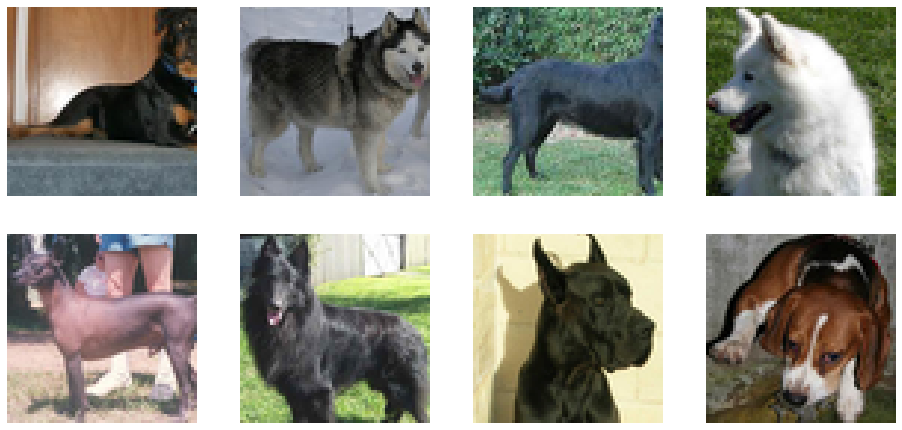

In [ ]:
fig = plt.figure(figsize=(16,16))

sample = np.random.randint(images_ds.shape[0], size=8)
for i, image in enumerate(images_ds[sample]):
    plt.subplot(4, 4, i+1)
    plt.imshow((image / 2) + 0.5)
    plt.axis('off')

plt.show()

In [ ]:
dog_features_tf = tf.cast(images_ds.astype(np.float16), 'float32')

In [ ]:
SAMPLE_SIZE = 22126
BATCH_SIZE = 256

In [ ]:
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(SAMPLE_SIZE).batch(BATCH_SIZE)

In [ ]:
NOISE_DIM = 128

In [ ]:
def gen_noise(batch_size):
	x_input = np.random.randn(NOISE_DIM * batch_size)
	x_input = x_input.reshape((batch_size, NOISE_DIM))
	return x_input

In [ ]:
def initialize_kernel():
    return RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
def make_generator_model():
    
    model = Sequential(name='generator')
    model.add(Dense(2048, input_shape=(NOISE_DIM,), kernel_initializer=initialize_kernel()))
    model.add(Reshape((4, 4, 128)))
    
    model.add(Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', kernel_initializer=initialize_kernel()))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    
    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel()))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel()))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel()))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel()))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(3, activation='tanh', kernel_initializer=initialize_kernel()))

    return model   

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638912   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         32

In [ ]:
def make_discriminator_model():
    
    model = Sequential(name='discriminator')
    
    model.add(Conv2D(64, (5, 5), strides=(1,1), padding='same', use_bias=False, input_shape=(64, 64, 3), kernel_initializer=initialize_kernel()))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel(), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel(), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initialize_kernel(), use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        102400    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)     

In [ ]:
INITIAL_LR_GEN=0.0002
INITIAL_LR_DIS=0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR_GEN, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR_DIS, beta_1=0.5)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss    

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
checkpoint_dir = PATH + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train_step(images):
    noise = gen_noise(BATCH_SIZE)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input, rows=8, cols=8, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(14,14))
    
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow((predictions[i, :, :, :]  / 2) + 0.5)
        plt.axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    if save:
        plt.savefig(PATH + 'images_progress/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def generate_test_image(model, noise_dim=NOISE_DIM):
    # test_input = tf.random.normal([1, noise_dim])
    test_input = gen_noise(1)
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :]  / 2) + 0.5)
    plt.axis('off') 
    plt.show()

In [ ]:
def train(dataset, epochs=300, initial_epoch=1):
    
    decay_step = 50
    lr_decay_steps = 1000
    logs  = open(PATH + 'logs.csv', 'w')
    print('epoch', 'np.mean(G_loss)', 'np.mean(D_loss)', sep=',', file=logs)

    initial_time = time.time()

    for epoch in tqdm(range(initial_epoch, epochs + initial_epoch)):
        
        G_loss = []; D_loss = []
        
        start = time.time()
        new_lr_gen = INITIAL_LR_GEN
        new_lr_dis = INITIAL_LR_DIS
        global_step = 0
        
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            global_step = global_step + 1
            G_loss.append(g_loss); D_loss.append(d_loss)
              
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, SEED, rows=8, cols=8, save=True)
        
        if (epoch + 1) % decay_step == 0:
            new_lr_gen = tf.train.cosine_decay(new_lr_gen, min(global_step, lr_decay_steps), lr_decay_steps)
            new_lr_dis = tf.train.cosine_decay(new_lr_dis, min(global_step, lr_decay_steps), lr_decay_steps)
            generator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_gen, beta_1=0.5)
            discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=new_lr_dis, beta_1=0.5)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generator.save(PATH + 'generator.h5')

        print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start),
              'Gen_loss mean: ', np.mean(G_loss), 'Disc_loss mean: ', np.mean(D_loss), sep='\n')
        
        print(epoch, np.mean(G_loss), np.mean(D_loss), sep=',', file=logs)
        
        if time.time() - initial_time > 40000:
            break
    
    logs.close()
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, SEED, rows=8, cols=8)
    checkpoint.save(file_prefix = checkpoint_prefix)
    generator.save(PATH + 'generator.h5')
    print('Final epoch.')

In [ ]:
!tail '/content/drive/My Drive/Colab Notebooks/generative-dog-images/logs.csv'

291,1.5884616,0.8336734
292,1.5856149,0.5794643
293,1.6413217,0.6782512
294,1.5588729,0.7740925
295,1.650618,0.5288684
296,1.470678,0.92376316
297,1.589099,0.65707284
298,1.8085033,0.5693089
299,1.5621341,0.65302384
300,1.4862355,0.8608943


In [ ]:
SEED = gen_noise(64)
# joblib.dump(SEED, PATH + 'seed.dump')

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
EPOCHS = 300
INITIAL_EPOCH = 1

In [ ]:
%%time
train(dog_features_data, EPOCHS, INITIAL_EPOCH)

In [ ]:
losses = pd.read_csv(PATH + 'logs.csv')
losses.head()

,epoch,np.mean(G_loss),np.mean(D_loss)
0,1,6.089914,0.351743
1,2,4.069351,0.344158
2,3,3.332214,0.321851
3,4,3.295769,0.340515
4,5,2.912070,0.331506


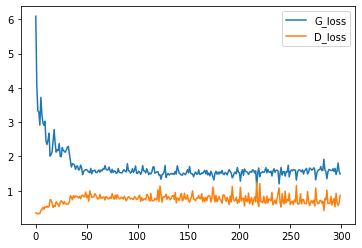

In [ ]:
plt.plot(losses['np.mean(G_loss)'], label='G_loss')
plt.plot(losses['np.mean(D_loss)'], label='D_loss')
plt.legend()
plt.show()

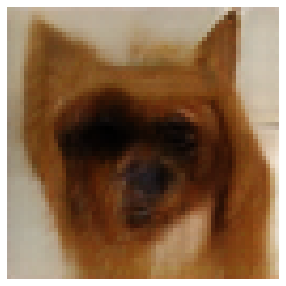

In [ ]:
generate_test_image(generator)

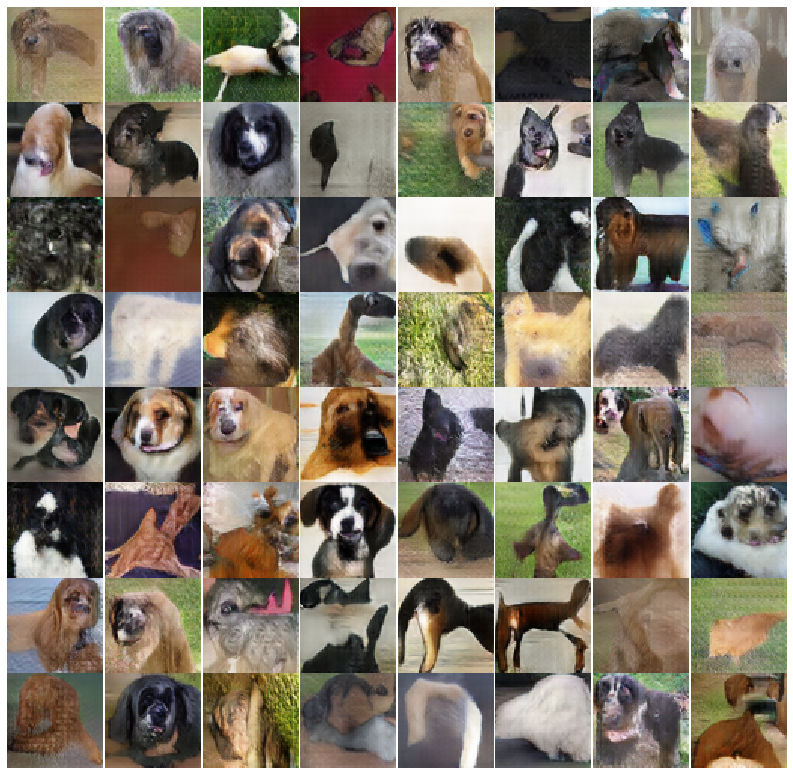

In [ ]:
generate_and_save_images(gen, EPOCHS, SEED, rows=8, cols=8, save=False)

In [ ]:
anim_file = PATH + 'images_progress.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(PATH + 'images_progress/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 1*(i**2)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)